# 基于随机森林实现港新股涨跌预测

任务：基于历史港新股数据，对新股涨跌进行预测

先看看港新股上市流程： 招股期（约5天）——  公布中签，同时下午暗盘（大约在招股期结束后7天） —— 上市（公布中签后的第一个工作日）。

由此可见，涨跌预测可以在两个时间点进行。其一是招股期，可优化申购策略；其二是公布中签后，可优化卖出策略。

# 1.数据读取

In [1]:
### 导入相关库
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
### 数据读取
import pandas as pd
# 利弗莫尔数据
lm_data = pd.read_csv('../data/livermore.csv',header = None)
lm_data.columns = ['code','complany','open_rise','close_rise','one_prob','must_count','issue_data','market',
				'plate','one_price','over_multiple','price','low_price','high_price',
				'greenshoe','ipo_sponsor','ipo_underwriter']
# 阿思达克网数据
as_data = pd.read_csv('../data/astocks.csv',header = None)
as_data.columns = ['code', 'one_count', 'value', 'total_count', 'HK_count', 'old_stock']
#合并数据
data0 = pd.merge(as_data, lm_data, on='code')
pd.set_option('display.max_columns', None)
data0.head(2)

,code,one_count,value,total_count,HK_count,old_stock,complany,open_rise,close_rise,one_prob,must_count,issue_data,market,plate,one_price,over_multiple,price,low_price,high_price,greenshoe,ipo_sponsor,ipo_underwriter
0,2129,"5,000","650,000,000","312,500,000","156,250,000",0,LEGION CONSO,15.0,-12.5,1.09,100,2021-01-13,仓储物流,主板,2626.20,442.37,0.4,0.4,0.52,有,丰盛融资有限公司,首盛资本集团有限公司、千里硕证券有限公司、高钲证券有限公司、丰盛融资有限公司、交银国际证券有...
1,1855,"2,000","665,500,000","68,750,000","20,626,000",0,中邦环境,-0.5,2.5,13.50,25,2021-01-06,建筑及装修,主板,4888.77,35.25,2.0,1.9,2.42,有,中国通海企业融资有限公司,中国通海证券有限公司、民银证券有限公司、申万宏源融资（香港）有限公司、西证（香港）证券经纪有...


## 数据介绍

- code —— 股票代码
- one_count —— 一手股数（和A股不同，港股一手股数非固定的100股，而是从几十到几千股不等）
- value —— 市值
- total_count —— 公开募集总股数（包括香港公开配售和国际配售两部分）
- HK_count —— 香港公开配售总股数
- old_stock —— 是否兜售旧股
- complany —— 公司名称
- open_rise —— 上市第一天开盘涨幅
- close_rise —— 上市第一天收盘涨幅
- one_prob —— 一手中签率
- must_count —— 必中一手最低所需申请手数
- issue_data —— 上市日期
- market —— 所属行业
- plate —— 上市板块（主板或者创业板）
- one_price —— 一手金额
- over_multiple —— 香港公开发售超购倍数
- price —— 最终定价
- low_price ——下限定价
- high_price —— 上限定价
- greenshoe —— 是否有绿鞋
- ipo_sponsor —— 保荐人
- ipo_underwriter —— 承销商

# 2.数据预处理

## 2.1 删除无关特征
基于业务逻辑，去除对于涨跌预测没有意义的特征：

code、one_count、complany、open_rise、must_count、issue_data、ipo_underwriter

其中open_rise（开盘涨幅）的表现，更多的是一种市场情绪的宣泄。恐慌时则互相踩踏，暴跌；贪婪时则互相抬轿，暴涨。而close_rise(收盘涨幅）在情绪宣泄之后，更趋于理性，是其基本面好坏更大程度的体现。 

故而选择close_rise作为本次预测的目标值。

In [3]:
data = data0[['total_count','HK_count','old_stock','market','plate','one_price','over_multiple',
           'price','low_price','high_price','greenshoe','ipo_sponsor','one_prob', 'close_rise']]

## 2.2 缺失值处理

观察发现，无缺失值，无需处理。

In [4]:
data.isnull().sum()

total_count      0
HK_count         0
old_stock        0
market           0
plate            0
one_price        0
over_multiple    0
price            0
low_price        0
high_price       0
greenshoe        0
ipo_sponsor      0
one_prob         0
close_rise       0
dtype: int64

## 2.3 数据类型转换

In [5]:
### 查看数据类型
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 0 to 880
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_count    881 non-null    object 
 1   HK_count       881 non-null    object 
 2   old_stock      881 non-null    int64  
 3   market         881 non-null    object 
 4   plate          881 non-null    object 
 5   one_price      881 non-null    float64
 6   over_multiple  881 non-null    float64
 7   price          881 non-null    float64
 8   low_price      881 non-null    float64
 9   high_price     881 non-null    float64
 10  greenshoe      881 non-null    object 
 11  ipo_sponsor    881 non-null    object 
 12  one_prob       881 non-null    float64
 13  close_rise     881 non-null    float64
dtypes: float64(7), int64(1), object(6)
memory usage: 103.2+ KB


In [6]:
### 将total_count、HK_count转换为float类型
data['total_count'] = data['total_count'].apply(lambda x: float(x.replace(',','')))
data['HK_count'] = data['HK_count'].apply(lambda x: float(x.replace(',','')))

## 2.4 新增特征

### 募资总金额

通常情况下，募资总金额代表该支股票上市初期中可买卖易手的筹码，这里用“流通市值”来表示。流通市值较小时，相对而言不需要太大的资金量就可以让股价暴涨暴跌，在香港市场容易吸引到一些机构或游资炒作。而流通市值特别大的公司，相对而言其股价变动会偏稳一些。

计算公式： circulate_value = total_count * price

In [7]:
data['circulate_value'] = data['total_count'] * data['price']

### 公开发售部分市值


在新股上市时期，通常情况下，公开发售部分（即散户）是所有筹码中抛售的中坚力量，对股价会有一定的影响。当遭逢踩踏式抛售时，股价能否稳住就看需要多少资金来承接这些筹码，这里直接用公开发售部分的市值来进行量化。

计算公式 ：open_value = HK_count * price


In [8]:
### 公开发售部分市值
data['open_value'] = data['HK_count'] * data['price']
# 删除HK_count、total_count
data.drop('HK_count', 1, inplace = True)
data.drop('total_count', 1, inplace = True)

### 定价方式

定价方式一般有三种：上限定价、中间定价和下限定价。

一般而言，采取下限定价，说明公司对于市场信心不足，同时也会打击市场对于公司的信心，从而影响其股价表现。

用0，1，2三位数字分别表示上限定价、中间定价和下限定价。

In [9]:
### 新增定价方式特征
data['pricing_type'] = 1
data.loc[data['price'] <= data['low_price'], 'pricing_type'] = 0
data.loc[data['price'] >= data['high_price'], 'pricing_type'] = 2
# 删除price、low_price、high_price
data.drop('price', 1, inplace = True)
data.drop('low_price', 1, inplace = True)
data.drop('high_price', 1, inplace = True)

In [10]:
data.head(2)

,old_stock,market,plate,one_price,over_multiple,greenshoe,ipo_sponsor,one_prob,close_rise,circulate_value,open_value,pricing_type
0,0,仓储物流,主板,2626.20,442.37,有,丰盛融资有限公司,1.09,-12.5,125000000.0,62500000.0,0
1,0,建筑及装修,主板,4888.77,35.25,有,中国通海企业融资有限公司,13.50,2.5,137500000.0,41252000.0,1


## 2.5 异常值处理

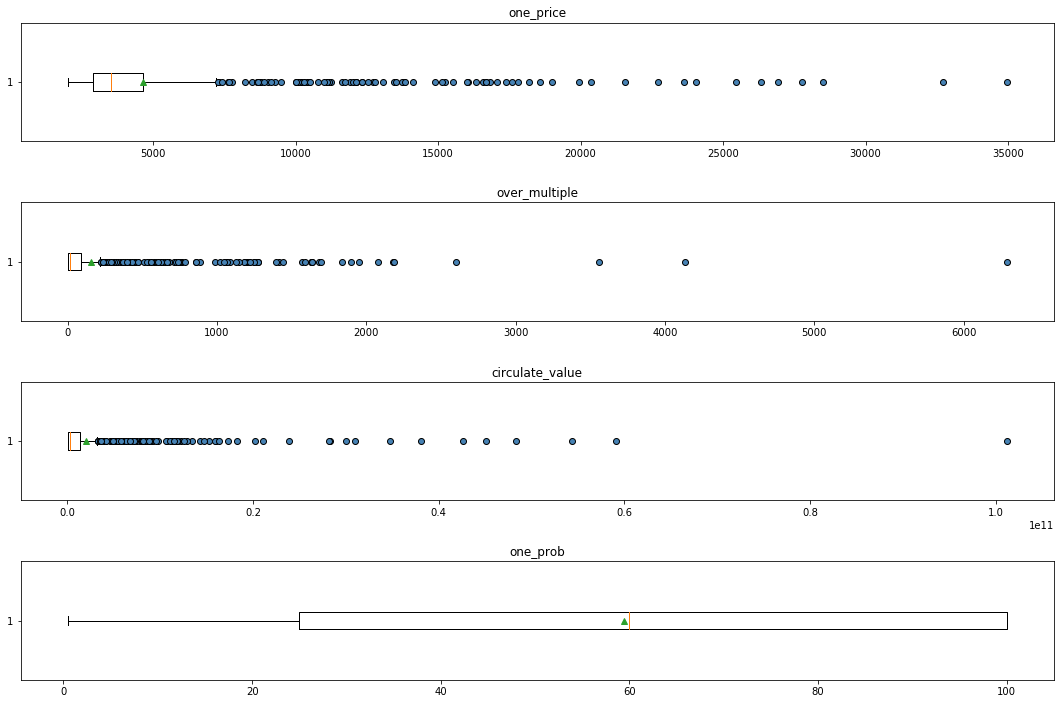

In [11]:
# 箱型图观察异常值情况
import seaborn as sns

#分析百分比特征
fig = plt.figure(figsize=(15,10)) # 建立图像

#one_price
ax1 = fig.add_subplot(411)
list1 = list(data['one_price'])
ax1.boxplot(list1,vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax1.set_title('one_price')

#over_multiple
ax1 = fig.add_subplot(412)
list2 = list(data['over_multiple'])
ax1.boxplot(list2,vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax1.set_title('over_multiple')

#circulate_value
ax1 = fig.add_subplot(413)
list3 = list(data['circulate_value'])
ax1.boxplot(list3,vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax1.set_title('circulate_value')

#one_prob
ax1 = fig.add_subplot(414)
list3 = list(data['one_prob'])
ax1.boxplot(list3,vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax1.set_title('one_prob')

plt.tight_layout(pad=1.5)
plt.show()

由图可知，在数值类特征中，除了one_prob，其它三列：one_price、over_multiple、circulate_value都存在不少的离群点。

但这些离群点都是业务中真实存在的值，并且最终发现，即便处理过后，随机森林的预测效果仍旧最优。而随机森林对于异常值的敏感度相对而言不高，所以这里不做处理。

# 3. 特征工程

## 3.1 类别特征处理

### market、plate
直接用标签进行编码，同时保存相应的标签编码器

In [12]:
import sklearn.preprocessing as sp

ibe_market = sp.LabelEncoder()
data['market'] = ibe_market.fit_transform(data['market'])
ibe_plate = sp.LabelEncoder()
data['plate'] = ibe_plate.fit_transform(data['plate'])

### greenshoe 
观察发现存在一个异常类别。将'无'用0标识，代表无绿鞋；其它的都标记为1，代表有绿鞋。

In [13]:
data.loc[data['greenshoe'] != '无', 'greenshoe'] = 1
data.loc[data['greenshoe'] == '无', 'greenshoe'] = 0
data['greenshoe'].value_counts()

1    660
0    221
Name: greenshoe, dtype: int64

### ipo_sponsor
观察发现，其Length为324。为方便分类计算，将具有多个保荐人的，取排在第一位的主保荐人

In [14]:
# 观察ipo_sponsor的取值情况
data['ipo_sponsor'].value_counts()

国泰君安融资有限公司                                                                                            29
丰盛融资有限公司                                                                                              23
创升融资有限公司                                                                                              21
汇富融资有限公司                                                                                              20
德健融资有限公司                                                                                              18
                                                                                                      ..
Merrill Lynch Far East Limited、花旗环球金融亚洲有限公司                                                            1
Merrill Lynch Far East Limited、海通国际资本有限公司、中信里昂证券资本市场有限公司、中国国际金融香港证券有限公司                                1
高盛（亚洲）有限责任公司、海通国际资本有限公司                                                                                1
J.P. Morgan Securities (Far East) Limited、Merrill Lynch

In [15]:
# 具备多个保荐人的，只取排在第一位的主保荐人
data['ipo_sponsor'] = data['ipo_sponsor'].apply(lambda x:x.split('、')[0].strip())
data['ipo_sponsor'].value_counts()

中国国际金融香港证券有限公司     45
摩根士丹利亚洲有限公司        39
高盛（亚洲）有限责任公司       31
国泰君安融资有限公司         30
建银国际金融有限公司         25
                   ..
银河—联昌证券（香港）有限公司     1
西证（香港）证券经纪有限公司      1
中国泛海企业融资有限公司        1
千里硕融资有限公司           1
创越融资有限公司            1
Name: ipo_sponsor, Length: 113, dtype: int64

In [16]:
# 标签编码
ibe_ipo_sponsor = sp.LabelEncoder()
data['ipo_sponsor'] = ibe_ipo_sponsor.fit_transform(data['ipo_sponsor'])

### close_rise —— 人工分类

In [17]:
# 用0，1分别代表跌、涨；close_rise大于0时为涨，否则为跌。
data.loc[data['close_rise'] > 0 , 'close_rise'] = 1
data.loc[data['close_rise'] <= 0 , 'close_rise'] = 0
data['close_rise'].value_counts()

1.0    520
0.0    361
Name: close_rise, dtype: int64

## 3.2 数值特征标准化

In [18]:
### 均值移除
data[['one_price','over_multiple','one_prob','circulate_value','open_value']] = sp.scale(
            data[['one_price','over_multiple','one_prob','circulate_value','open_value']]
)
data.head()

,old_stock,market,plate,one_price,over_multiple,greenshoe,ipo_sponsor,one_prob,close_rise,circulate_value,open_value,pricing_type
0,0,1,0,-0.539240,0.684073,1,28,-1.588754,0.0,-0.303116,-0.329560,0
1,0,27,0,0.061259,-0.278810,1,21,-1.250766,1.0,-0.301116,-0.361065,1
2,0,67,0,-0.054015,-0.292031,1,10,-1.346089,1.0,-0.294794,-0.343497,1
3,0,1,1,0.023731,-0.279638,0,69,-1.202832,1.0,-0.314240,-0.397543,0
4,0,60,0,-0.566046,-0.285031,1,71,-1.346089,1.0,-0.302956,-0.384865,0


## 3.3 数值特征选择

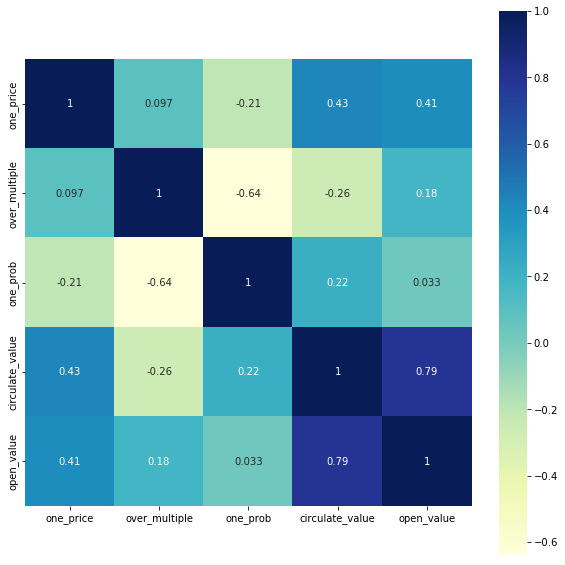

In [19]:
import seaborn as sns
nu_fea = ['one_price','over_multiple','one_prob','circulate_value','open_value']  # 选择连续型数值特征计算相关系数
pearson_mat = data[nu_fea].corr(method='spearman')  # 计算皮尔逊相关系数矩阵

# 用热度图表示相关系数矩阵
plt.figure(figsize=(10,10))
sns.heatmap(pearson_mat,square=True, annot=True, cmap='YlGnBu')
plt.show()

观察发现，open_value 和 circulate_value相关度达到0.79， 选择将 open_value 删除

In [20]:
data.drop('open_value',1,inplace = True)

# 4. 类别不平衡处理

In [21]:
# 观察正负样本分布
data['close_rise'].value_counts()

1.0    520
0.0    361
Name: close_rise, dtype: int64

正负样本比例为 1.44:1 ，差别不是特别大，暂时不做处理

# 5.招股期涨跌预测

招股期间，涨跌预测太重要了，它直接关系到这只股票是否要参与。

而这个期间，one_prob（一手中签率）、pricing_type（定价方式）这两个数据我们无法得到。它们只有在分配书公布之后才能获取。

In [22]:
# ipo_data为招股期间的数据
ipo_data = data.drop(['one_prob', 'pricing_type'],1)

## 5.1 交叉验证

同样考虑到样本数较少的问题，本案例采用K折交叉验证的方式进行预测，提高数据利用率；此外，采用逻辑回归、SVM、随机森林、AdaBoost等算法构建模型，从中选择预测效果较好的模型进行最终的预测。

在新股涨跌预测中，很明显，更应该关注的指标为查准率，即每一个类别中，预测正确的样本数比上预测出来的样本数。

比如：模型预测了10只股票会涨，而真实上涨的有7只，代表查准率为70%。很明显，查准率越高，代表着新股获利的概率越高。所以它是整个新股涨跌预测中最重要的指标。

In [23]:
import sklearn.model_selection as ms
import sklearn.ensemble as se
import sklearn.metrics as sm

from sklearn.linear_model import LogisticRegression as LR    # 逻辑回归
from sklearn.svm import SVC    # SVM
from sklearn.ensemble import RandomForestClassifier as RF    # 随机森林
from sklearn.ensemble import AdaBoostClassifier as Adaboost    # AdaBoost

### 整理数据集
x = ipo_data.drop('close_rise',1)
y = ipo_data['close_rise']
#数据集划分
train_x, test_x, train_y, test_y = ms.train_test_split(
        x, y, test_size=0.2, random_state=0)
# 交叉验证
model_list = [LR, SVC, RF, Adaboost]
pred_list = []
for m in model_list:
    # 获取预测结果
    pred = ms.cross_val_predict(m(), train_x, train_y, cv=5)
    pred_list.append(pred)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### 交叉验证各指标得分

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score    # 导入精确率、召回率、F1值等评价指标

scoreDf = pd.DataFrame(columns=['LR', 'SVC', 'RandomForest', 'AdaBoost'])
for i in range(4):
    r = recall_score(train_y, pred_list[i])
    p = precision_score(train_y, pred_list[i])
    f1 = f1_score(train_y, pred_list[i])
    scoreDf.iloc[:, i] = pd.Series([r, p, f1])

scoreDf.index = ['Recall', 'Precision', 'F1-score']
scoreDf

,LR,SVC,RandomForest,AdaBoost
Recall,0.922170,0.825472,0.669811,0.738208
Precision,0.611894,0.618375,0.674584,0.631048
F1-score,0.735654,0.707071,0.672189,0.680435


由上表可知，随机森林模型的查准率得分最高，可以用RandomForestClassifier单模型进行预测

## 5.2 网格搜素

In [34]:
from sklearn.model_selection import GridSearchCV
clf = RF(random_state=2)
param_grid = {
    'n_estimators':np.arange(10,201,10),
    'max_features':np.arange(0.1,1,0.1),
    'max_depth':np.arange(3,11,1),
    'bootstrap':[True, False],
}
grid1 = GridSearchCV(clf, param_grid = param_grid, cv = 5)
grid1.fit(train_x, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200]), 'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]), 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [35]:
# 获取最优参数、最优得分
print(grid1.best_params_)
print(grid1.best_score_)

{'bootstrap': False, 'max_depth': 8, 'max_features': 0.30000000000000004, 'n_estimators': 40}
0.6491477272727273


## 5.3 模型评估


In [41]:
model = RF(max_depth=8, n_estimators=40,bootstrap=False, max_features=0.3, random_state=2)
model.fit(train_x, train_y)
pred_test_y = model.predict(test_x)

# 混淆矩阵、分类报告
print(sm.confusion_matrix(test_y, pred_test_y))
print(sm.classification_report(test_y, pred_test_y))

[[34 47]
 [28 68]]
             precision    recall  f1-score   support

        0.0       0.55      0.42      0.48        81
        1.0       0.59      0.71      0.64        96

avg / total       0.57      0.58      0.57       177



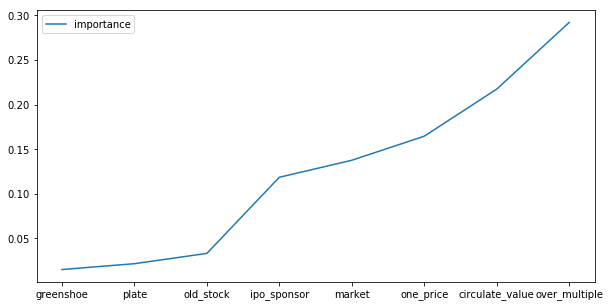

,importance
greenshoe,0.015180
plate,0.021735
old_stock,0.033256
ipo_sponsor,0.118543
market,0.137565
one_price,0.164526
circulate_value,0.217271
over_multiple,0.291925


In [37]:
### 特征重要性
feature_importances = pd.DataFrame(model.feature_importances_,
                                  index = ipo_data.columns.drop(['close_rise']),
                                  columns = ['importance']).sort_values('importance')
# 可视化
feature_importances.plot(figsize=(10,5))
plt.show()
feature_importances

## 5.4 预测概率值

模型的预测效果一般。为提高胜率，可以预测上涨的概率，根据个人风险偏好设定阀值选择是否参与

In [39]:
# 预测新股上涨的概率值
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state = 0)
y_prob = np.zeros(len(y))  # 初始化预测概率值数组
# 预测概率值
for train_index, test_index in kf.split(x):
    x_train = x.iloc[train_index]
    x_test = x.iloc[test_index]
    y_train = y.iloc[train_index]
#     clf = RF(max_depth=4, n_estimators=150,bootstrap=True, max_features=0.3, random_state=5)
    clf = RF(max_depth=8, n_estimators=40,bootstrap=False, max_features=0.3, random_state=5)
    clf.fit(x_train,y_train)
    y_prob[test_index] = clf.predict_proba(x_test)[:,1]
prob = np.round(y_prob, 1)   # 对预测出的概率值保留一位小数，便于分组观察

# # 合并预测值和真实值
probDf = pd.DataFrame(prob)
churnDf = pd.DataFrame(y)
df1 = pd.concat([probDf.reset_index(drop=True), churnDf.reset_index(drop=True)], axis=1)
df1.columns = ['prob', 'close_rise']

# 分组计算每种预测概率值所对应的真实上涨概率
group = df1.groupby('prob')
df2 = pd.concat([group.count(), group.sum()/group.count()], axis=1).reset_index()
df2.columns = ['prob', 'close_rise', 'true_prob']
df2

,prob,close_rise,true_prob
0,0.2,7,0.428571
1,0.3,22,0.590909
2,0.4,116,0.491379
3,0.5,240,0.558333
4,0.6,202,0.569307
5,0.7,150,0.626667
6,0.8,101,0.702970
7,0.9,42,0.761905
8,1.0,1,1.000000


由表可知：随着预测上涨概率增加，其真实上涨概率虽然上下波动，但趋势上还是有所增加的。

根据个人风险偏好，可以根据各预测概率值分组的真实上涨概率设定阈值进行决策。例如，设置阈值为true_prob = 0.7，即优先关注真正上涨概率为70%以上的股票，也就表示可以对预测结果中大于等于0.8的股票进行参与。

# 6.公布中签后涨跌预测

一般港交所会在上市前一天早上披露分配书，透过分配书，我们能获取到data的完整数据。

此刻可用相对完整的数据对新股涨跌再次预测，以应对下午的暗盘和第二天的上市。

接下来的步骤和招股期间的涨跌预测除了数据源不一样，其它基本一致。

## 6.1 交叉验证

同样考虑到样本数较少的问题，本案例采用K折交叉验证的方式进行预测，提高数据利用率；此外，采用逻辑回归、SVM、随机森林、AdaBoost等算法构建模型，从中选择预测效果较好的模型进行最终的预测。

在新股涨跌预测中，很明显，更应该关注的指标为查准率，即每一个类别中，预测正确的样本数比上预测出来的样本数。

比如：模型预测了10只股票会涨，而真实上涨的有7只，代表查准率为70%。很明显，查准率越高，代表着新股获利的概率越高。所以它是整个新股涨跌预测中最重要的指标。

In [42]:
import sklearn.model_selection as ms
import sklearn.ensemble as se
import sklearn.metrics as sm

from sklearn.linear_model import LogisticRegression as LR    # 逻辑回归
from sklearn.svm import SVC    # SVM
from sklearn.ensemble import RandomForestClassifier as RF    # 随机森林
from sklearn.ensemble import AdaBoostClassifier as Adaboost    # AdaBoost

### 整理数据集
x = data.drop('close_rise',1)
y = data['close_rise']
#数据集划分
train_x, test_x, train_y, test_y = ms.train_test_split(
        x, y, test_size=0.2, random_state=0)
# 交叉验证
model_list = [LR, SVC, RF, Adaboost]
pred_list = []
for m in model_list:
    # 获取预测结果
    pred = ms.cross_val_predict(m(), train_x, train_y, cv=5)
    pred_list.append(pred)

### 交叉验证各指标得分

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score    # 导入精确率、召回率、F1值等评价指标

scoreDf = pd.DataFrame(columns=['LR', 'SVC', 'RandomForest', 'AdaBoost'])
for i in range(4):
    r = recall_score(train_y, pred_list[i])
    p = precision_score(train_y, pred_list[i])
    f1 = f1_score(train_y, pred_list[i])
    scoreDf.iloc[:, i] = pd.Series([r, p, f1])

scoreDf.index = ['Recall', 'Precision', 'F1-score']
scoreDf

,LR,SVC,RandomForest,AdaBoost
Recall,0.875000,0.820755,0.632075,0.738208
Precision,0.622483,0.617021,0.647343,0.632323
F1-score,0.727451,0.704453,0.639618,0.681175


由上表可知，随机森林模型的查准率得分最高，可以用RandomForestClassifier单模型进行预测

## 6.2 网格搜索

In [52]:
from sklearn.model_selection import GridSearchCV
clf = RF(random_state=5)
# 超参数字典
param_grid = {
    'n_estimators':np.arange(10,201,10),
    'max_features':np.arange(0.1,1,0.1),
    'max_depth':np.arange(3,11,1),
    'bootstrap':[True, False],
}
# 网格搜索
grid2 = GridSearchCV(clf, param_grid = param_grid, cv = 5)
grid2.fit(train_x, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200]), 'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]), 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [53]:
# 获取最优参数、最优得分
print(grid2.best_params_)
print(grid2.best_score_)
print(grid2.best_index_)

{'bootstrap': False, 'max_depth': 5, 'max_features': 0.30000000000000004, 'n_estimators': 170}
0.6519886363636364
1856


## 6.3 模型评估

In [62]:
### 获取测试集各指标得分
model = RF(max_depth=5, n_estimators=170,bootstrap=False, max_features=0.3 , random_state=5)
model.fit(train_x, train_y)
pred_test_y = model.predict(test_x)

# 混淆矩阵、分类报告
print(sm.confusion_matrix(test_y, pred_test_y))
print(sm.classification_report(test_y, pred_test_y))

[[28 53]
 [24 72]]
             precision    recall  f1-score   support

        0.0       0.54      0.35      0.42        81
        1.0       0.58      0.75      0.65        96

avg / total       0.56      0.56      0.55       177



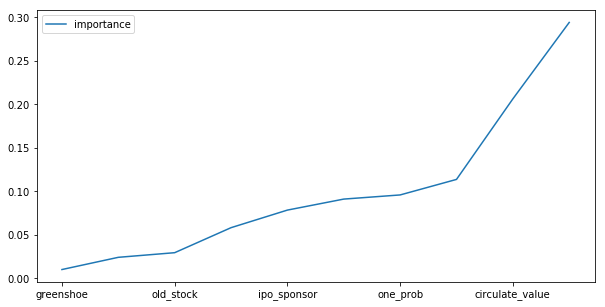

,importance
greenshoe,0.009948
plate,0.023993
old_stock,0.029316
pricing_type,0.058074
ipo_sponsor,0.078290
market,0.090946
one_prob,0.095713
one_price,0.113558
circulate_value,0.206140
over_multiple,0.294022


In [63]:
### 特征重要性
feature_importances = pd.DataFrame(model.feature_importances_,
                                  index = data.columns.drop(['close_rise']),
                                  columns = ['importance']).sort_values('importance')
# 可视化
feature_importances.plot(figsize=(10,5))
plt.show()
feature_importances

## 6.4 结合预测概率值

模型对于涨跌预测的效果一般，所以结合预测的概率值来筛选胜率更大大的新股

In [64]:
# 预测新股上涨的概率值
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state = 0)
y_prob = np.zeros(len(y))  # 初始化预测概率值数组
# 预测概率值
for train_index, test_index in kf.split(x):
    x_train = x.iloc[train_index]
    x_test = x.iloc[test_index]
    y_train = y.iloc[train_index]
    clf = RF(max_depth=5, n_estimators=170,bootstrap=False, max_features=0.3 , random_state=5)

    clf.fit(x_train,y_train)
    y_prob[test_index] = clf.predict_proba(x_test)[:,1]
prob = np.round(y_prob, 1)   # 对预测出的概率值保留一位小数，便于分组观察

# # 合并预测值和真实值
probDf = pd.DataFrame(prob)
churnDf = pd.DataFrame(y)
df3 = pd.concat([probDf.reset_index(drop=True), churnDf.reset_index(drop=True)], axis=1)
df3.columns = ['prob', 'close_rise']
df3.head()

# 分组计算每种预测概率值所对应的真实上涨概率
group = df3.groupby('prob')
df4 = pd.concat([group.count(), group.sum()/group.count()], axis=1).reset_index()
df4.columns = ['prob', 'close_rise', 'true_prob']
df4

,prob,close_rise,true_prob
0,0.3,6,0.500000
1,0.4,125,0.496000
2,0.5,233,0.480687
3,0.6,223,0.609865
4,0.7,199,0.678392
5,0.8,69,0.739130
6,0.9,26,0.807692


由表可知：随着预测上涨概率增加，其真实上涨概率虽然上下波动，但趋势上还是有所增加的。

根据个人风险偏好，可以根据各预测概率值分组的真实上涨概率设定阈值进行决策。

例如，假设阈值为true_prob = 0.5，即优先关注真正上涨概率为50%以下的股票，也就表示对预测结果中小于0.6的股票，在暗盘时要小心它们破发，及时止损。

# 7.总结

模型对于涨跌预测效果不佳，这个在预料之中，毕竟资本市场最为扑朔迷离。

一般新股上市的表现，受两大因素影响。其一是基本面，其二是情绪面。并且情绪面较于基本面，对股价的拉扯更为有力。

市场情绪好比女人的脸，说翻就翻，极难把控。

而基本面，远不是我们本次使用data数据中的各项特征可以穷尽的。国配热度、基石投资占比、阵容、估值高低、盈利能力、增长……这些都是基本面中较为重要的角色，并且是data中所缺失的。

所以只用基本面的一部分作为依据去做涨跌预测，其效果必然受限。

饶是如此，通过对上涨概率预测，也提高了不小的胜率。

In [65]:
# 招股期内预测上涨概率对应的真实上涨概率
df2

,prob,close_rise,true_prob
0,0.2,7,0.428571
1,0.3,22,0.590909
2,0.4,116,0.491379
3,0.5,240,0.558333
4,0.6,202,0.569307
5,0.7,150,0.626667
6,0.8,101,0.702970
7,0.9,42,0.761905
8,1.0,1,1.000000


观察上表，如果挑选预测概率大于等于0.8的参与，其真实上涨概率也超过了70%。从量化交易的角度来看，70%的胜率相当不错了。并且在881支股票中，预测值大于等于0.8的一共有144支股票，参与机会也不算少。

In [68]:
# 公布中签后预测上涨概率对应的真实上涨概率
df4

,prob,close_rise,true_prob
0,0.3,6,0.500000
1,0.4,125,0.496000
2,0.5,233,0.480687
3,0.6,223,0.609865
4,0.7,199,0.678392
5,0.8,69,0.739130
6,0.9,26,0.807692


观察上表，根据个人风险便好可制定相应策略。

比如预测上涨概率小于0.6，那么它的真实上涨概率基本上在50%以下，这些股票需要格外小心，情况不对就要及时止损。

而如果预测上涨概率大于等于0.8，其真实上涨概率超过73.9%。如果其股价有贴近发行价的机会，胆大的甚至可以吸筹，待机会高抛。

** 总体来看，模型对于上涨概率的预测已经取得效果，具备了一定的参考价值！**